In [1]:
import cryptpandas as crp
import os
import getpass
import pandas as pd
import numpy as np
import torch
print(f'torch {torch.__version__}')
from sklearn.preprocessing import minmax_scale, MinMaxScaler
import json
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
from datetime import date

from data_manip import remove_incomplete_days
from preproc import import_and_preprocess_data, create_and_add_datetime_features
from GAN import GAN
from plot import plot_losses
from plot import plot_synthetic_vs_real_samples

torch 2.1.1+cu121


### Data import

In [2]:
GAN_data_path = Path().absolute().parent / 'GAN_data'

df_loadProfiles = crp.read_encrypted(path = os.path.join(GAN_data_path, 'all_profiles.crypt'), password="Ene123Elec#4")#getpass.getpass('Password: '))

In [3]:
df_labels = pd.read_csv(os.path.join(GAN_data_path, 'DBSCAN_15_clusters_labels.csv'), sep = ';')
df_labels['name'] = df_labels['name'].str.split('_', expand = True)[1]

### Create a dataframe for one cluster

In [9]:
clusterLabel = 1

profiles = df_labels.loc[df_labels['labels'] == clusterLabel, 'name'].to_list()[:30]
print(len(profiles))

df_profiles = df_loadProfiles[df_loadProfiles.columns[:13].tolist() + [item for item in profiles if item in df_loadProfiles.columns]].copy()
df_plot = df_profiles.iloc[:, 13:].reset_index(drop = True).copy()    #save for later

df_profiles = df_profiles.melt(id_vars = df_loadProfiles.columns[:13], value_vars = df_profiles.columns[13:], var_name = 'profile')
df_profiles = df_profiles.pivot_table(values = 'value', index = ['date', 'profile'], columns = 'hour of the day')

30


In [53]:
df_profiles = df_loadProfiles[df_loadProfiles.columns[:13].tolist() + [item for item in profiles if item in df_loadProfiles.columns]].copy()
df_profiles

,timestamp,date,year,meteorological season,month,month of the year,week of the year,day of the month,weekday,hour of the day,...,5787,5793,5927,5931,6023,6051,607,6085,67,765
0,2021-06-01 00:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,1,...,52.0,62.0,211.0,124.0,56.0,53.0,0.0,260.0,59.0,5.0
1,2021-06-01 01:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,2,...,28.0,64.0,172.0,360.0,59.0,65.0,0.0,75.0,72.0,2.0
2,2021-06-01 02:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,3,...,28.0,66.0,130.0,15.0,64.0,21.0,0.0,66.0,58.0,3.0
3,2021-06-01 03:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,4,...,28.0,65.0,116.0,15.0,63.0,65.0,0.0,83.0,38.0,3.0
4,2021-06-01 04:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,5,...,28.0,67.0,62.0,15.0,62.0,57.0,0.0,95.0,47.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,2022-06-30 19:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,20,...,531.0,67.0,161.0,11.0,142.0,98.0,0.0,161.0,161.0,10.0
9476,2022-06-30 20:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,21,...,491.0,172.0,409.0,12.0,125.0,153.0,0.0,1380.0,954.0,14.0
9477,2022-06-30 21:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,22,...,598.0,241.0,238.0,12.0,162.0,144.0,0.0,836.0,515.0,5.0
9478,2022-06-30 22:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,23,...,445.0,401.0,323.0,12.0,196.0,110.0,0.0,288.0,78.0,15.0


In [57]:
df_melted = df_profiles.melt(id_vars = df_loadProfiles.columns[:13], value_vars = df_profiles.columns[13:], var_name = 'profile')
df_melted

,timestamp,date,year,meteorological season,month,month of the year,week of the year,day of the month,weekday,hour of the day,day off,weekend,holiday,profile,value
0,2021-06-01 00:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,1,0,0,0,10,6.0
1,2021-06-01 01:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,2,0,0,0,10,6.0
2,2021-06-01 02:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,3,0,0,0,10,7.0
3,2021-06-01 03:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,4,0,0,0,10,6.0
4,2021-06-01 04:00:00,2021-06-01,2021,Summer,June,6,22,1,Tuesday,5,0,0,0,10,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976435,2022-06-30 19:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,20,0,0,0,765,10.0
976436,2022-06-30 20:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,21,0,0,0,765,14.0
976437,2022-06-30 21:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,22,0,0,0,765,5.0
976438,2022-06-30 22:00:00,2022-06-30,2022,Summer,June,6,26,30,Thursday,23,0,0,0,765,15.0


In [58]:
df_melted.pivot_table(values = 'value', index = ['date', 'profile'], columns = 'hour of the day')

hour of the day         1       2       3       4       5       6       7   \
date       profile                                                           
2021-06-01 10          6.0     6.0     7.0     6.0     6.0     6.0     6.0   
           1024      297.0   261.0    19.0    18.0    69.0    96.0    67.0   
           1169      187.0   114.0   121.0   110.0   501.0   206.0   164.0   
           1185     2741.0  2295.0  2289.0  2302.0  2311.0  2298.0  1320.0   
           1212      115.0   115.0    90.0   265.0   114.0    81.0   114.0   
...                    ...     ...     ...     ...     ...     ...     ...   
2022-06-30 6051      108.0   145.0   136.0   114.0   124.0   157.0   120.0   
           607         0.0     0.0     0.0     0.0     0.0     0.0     0.0   
           6085      214.0   505.0   150.0   116.0   128.0   232.0   122.0   
           67          3.0     4.0     3.0     4.0     3.0     4.0     3.0   
           765         3.0     3.0     2.0     3.0     3.0     9.0     5.0   

hour of the day         8      9       10  ...     15      16     17     18  \
date       profile                         ...                                
2021-06-01 10          6.0    6.0    21.0  ...    6.0     6.0    6.0    6.0   
           1024       16.0   17.0    93.0  ...  446.0   410.0  379.0  383.0   
           1169     1133.0  627.0   117.0  ...  880.0   399.0  314.0  224.0   
           1185        2.0    1.0     1.0  ...    2.0     1.0    1.0    1.0   
           1212       90.0  415.0   103.0  ...  203.0   314.0  129.0   88.0   
...                    ...    ...     ...  ...    ...     ...    ...    ...   
2022-06-30 6051      101.0  139.0   125.0  ...  113.0    80.0  184.0  123.0   
           607         0.0    0.0     0.0  ...    0.0     0.0    0.0    0.0   
           6085      225.0  429.0  1330.0  ...  263.0  1092.0  451.0  227.0   
           67          3.0   45.0   460.0  ...  608.0   170.0  660.0  259.0   
           765         2.0    3.0     3.0  ...    3.0     7.0    3.0    2.0   

hour of the day         19     20      21      22      23      24  
date       profile                                                 
2021-06-01 10          6.0    7.0    51.0     6.0    20.0     7.0  
           1024      311.0  129.0   264.0   430.0   363.0   428.0  
           1169      671.0  205.0  2972.0  1423.0   903.0   310.0  
           1185        1.0    2.0     1.0  1312.0  3114.0  3140.0  
           1212      113.0  141.0   597.0   191.0   192.0   153.0  
...                    ...    ...     ...     ...     ...     ...  
2022-06-30 6051       99.0   98.0   153.0   144.0   110.0    95.0  
           607         0.0    0.0     0.0     0.0     0.0     0.0  
           6085     1823.0  161.0  1380.0   836.0   288.0   174.0  
           67        348.0  161.0   954.0   515.0    78.0    58.0  
           765         5.0   10.0    14.0     5.0    15.0    14.0  

[40685 rows x 24 columns]

### Create and scale samples and labels

In [10]:
samples = df_profiles.to_numpy()
labels = np.array(range(len(df_profiles)))

### Configure GAN

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU is used.')
else:
    device = torch.device('cpu')
    print('CPU is used.')

batchSize = 1000
dimLatent = 32
featureCount = samples.shape[1]
classCount = len(set(labels))
dimEmbedding = 5000
lr = 1e-5
maxNorm = 1e6
epochCount = 200
#testLabel = 0

GPU is used.


### Create and run model

In [7]:
model = GAN(
    name = "current_model",
    device = device,
    batchSize = batchSize,
    samples = samples,
    labels = labels,
    dimLatent = dimLatent,
    featureCount = featureCount,
    classCount = classCount,
    dimEmbedding = dimEmbedding,
    lr = lr,
    maxNorm = maxNorm,
    epochCount = epochCount,
    #testLabel = testLabel
)
print("1")
torch.cuda.empty_cache()
print("Test")
model.train()

1
Test


100%|█████████████████████████████████████████| 200/200 [45:36<00:00, 13.68s/it]


### Save model

In [8]:
model.name = f'model_philipp_test_batch_size_{batchSize}_dimEmbeding_{dimEmbedding}_epoch_count_{epochCount}'
torch.save(model, f'models/{model.name}.pt')

In [43]:
import torch
import GAN
model = torch.load("models/model_test_andi.pt")

In [6]:
model.dimEmbedding

100

In [7]:
model.Gen.labelEmbedding

Embedding(11850, 100)

In [39]:
df_real = df_profiles.reset_index().melt(id_vars=["date","profile"]).pivot_table(values="value", columns="profile", index=["date", "hour of the day"])

In [44]:
array = model.generate_sample()
df_synthProfiles = df_profiles.copy()
df_synthProfiles[::] = array
df_synthetic = df_synthProfiles.reset_index().melt(id_vars=["date","profile"]).pivot_table(values="value", columns="profile", index=["date", "hour of the day"])


In [42]:
df_synthetic.shape == df_real.shape


True

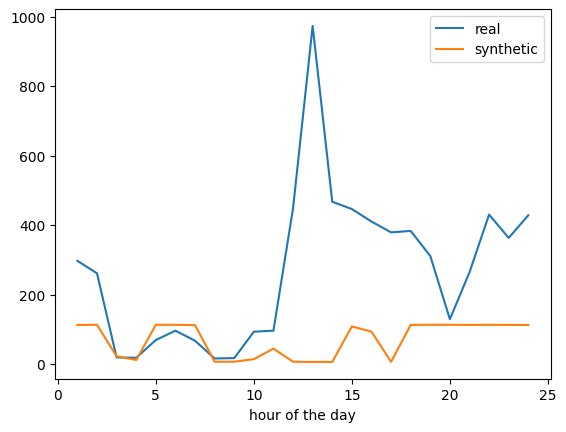

In [46]:
df_profiles.iloc[1].plot(label="real")
df_synthProfiles.iloc[1].plot(label="synthetic")
plt.legend()

<Axes: xlabel='hour of the day'>

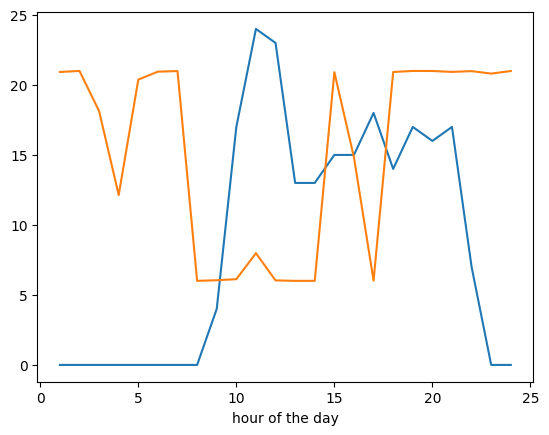

In [49]:
df_profiles.iloc[100].plot()
df_synthProfiles.iloc[100].plot()

<Axes: xlabel='hour of the day'>

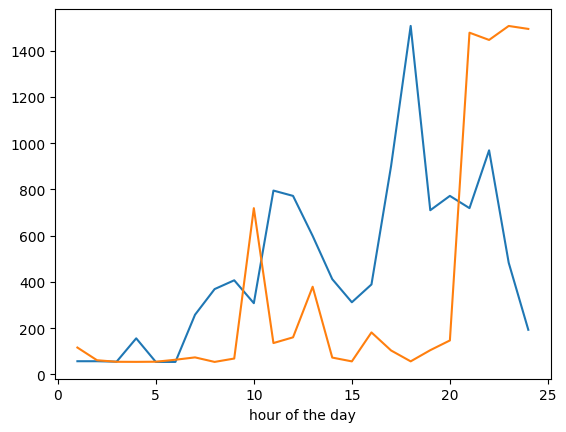

In [17]:
df_profiles.iloc[5].plot()
df_synthProfiles.iloc[5].plot()

### Generate synthetic profiles

In [18]:
df_synthProfiles

hour of the day             1           2          3          4           5   \
date       profile                                                             
2021-06-01 10        29.777325   25.284399  18.176878  17.676056   19.446388   
           1024     785.025024  295.832062  95.172264  86.388367  114.016029   
           1169      97.000000   97.000000  97.000000  97.000000   97.000000   
           1185       1.000000    1.000000   1.000000   1.000000    1.000000   
           1212     223.199051  118.022919  97.568489  97.950294  101.743706   
...                        ...         ...        ...        ...         ...   
2022-06-30 5927      68.000000   68.000000  68.000000  68.000000   68.000000   
           5931      11.000000   11.000000  11.000000  11.000000   11.000000   
           6023      59.000004   59.000004  59.000004  59.000004   59.000004   
           6051      88.999298   84.498070  82.249825  81.467758   81.710335   
           607        0.000000    0.000000   0.000000   0.000000    0.000000   

hour of the day             6           7          8           9   \
date       profile                                                  
2021-06-01 10        20.567095   34.352585   8.019791   11.220529   
           1024     308.870239  728.504761  16.878469   22.910624   
           1169      97.000000   97.000000  97.000000  116.549644   
           1185       1.000000    1.000000   1.000000   37.369423   
           1212     140.023926  274.400024  84.547722  125.084618   
...                        ...         ...        ...         ...   
2022-06-30 5927      68.000000   68.000000  68.000000   69.725655   
           5931      11.000000   11.000000  11.000000   11.010431   
           6023      59.000004   59.000004  59.000004   59.000141   
           6051      84.853897   96.595474  81.397675   96.762535   
           607        0.000000    0.000000   0.000000    0.133571   

hour of the day              10  ...          15           16          17  \
date       profile               ...                                        
2021-06-01 10         23.589460  ...   11.124401    12.703090   14.454088   
           1024      124.765182  ...   20.080046    37.451679   47.340763   
           1169     2941.182861  ...  153.686920  1478.827148  684.697205   
           1185     3077.606689  ...   13.823483  2800.050049  805.251099   
           1212      294.237549  ...  113.430832   174.612244  166.775909   
...                         ...  ...         ...          ...         ...   
2022-06-30 5927     1097.912354  ...   78.769272   915.074524   78.604774   
           5931       12.980704  ...   11.204555    12.936687   11.694054   
           6023      983.998901  ...   61.621777   983.227356   59.612598   
           6051      123.488480  ...   91.013969   114.543930  101.153587   
           607         0.999713  ...    0.000543     0.999700    0.645472   

hour of the day             18           19          20          21  \
date       profile                                                    
2021-06-01 10         8.436914    15.972526   18.496704   48.080372   
           1024      16.888680    55.439449  100.683800  969.060547   
           1169     101.182465  1993.450928  114.881683  876.229736   
           1185      13.056004   824.758057   20.198227   58.438168   
           1212      90.485794   183.153824  194.009125  546.113098   
...                        ...          ...         ...         ...   
2022-06-30 5927      69.282524   925.625244   69.716629   75.411209   
           5931      11.000423    12.760289   11.010998   11.037743   
           6023      59.071457   734.391663   59.615025   59.026993   
           6051      84.720726   108.482414  113.040962  162.269775   
           607        0.000003     0.104926    0.000002    0.000584   

hour of the day             22           23          24  
date       profile                                       
2021-06-01 10      

In [19]:
numberOfProfiles = 90

synthSamplesScaled_list = [model.generate_sample() for i in range(numberOfProfiles)]
synthSamples_list = [scaler.inverse_transform(item.T).T for item in synthSamplesScaled_list]

synthSamplesScaled = np.dstack(synthSamplesScaled_list)
synthSamples = np.dstack(synthSamples_list)

NameError: name 'scaler' is not defined

In [ ]:
df_profiles

In [ ]:
df_synthProfiles = df_profiles.copy()
df_synthProfiles[::] = scaler.inverse_transform(model.generate_sample().T).T

In [ ]:
df_profiles.iloc[5].plot()

In [ ]:
df_synthProfiles.iloc[5].plot()

In [ ]:
pd.DataFrame(scaler.inverse_transform(model.generate_sample().T).T, columns = df_profiles)

In [ ]:
model.generate_sample().shape

### Create plots

In [ ]:
plot_synthetic_vs_real_samples(
    model = model,
    df_profile = df_profiles,
    samplesScaled = samplesScaled,
    synthSamples = synthSamplesScaled
)

In [ ]:
plot_losses(model = model)